# ECRQ Tables and Graphs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.weightstats import ttest_ind
from scipy import stats
import re
import seaborn as sns

In [2]:
# Read only total_tract_population column from acs_data.csv
density_pop = pd.read_csv(
    "../data/acs_data_all_2022.csv",
    usecols=["tract", "density"],
    dtype={"density": np.float32, "tract": str},
)
density_pop.columns

Index(['tract', 'density'], dtype='object')

In [3]:
shares_pop = pd.read_csv(
    "../data/tract_population_shares_2022.csv",
    usecols=[
        "state",
        "county",
        "tract",
        "Share of White Population",
        "Share of Black Population",
        "Share of American Indian and Alaska Native Population",
        "Share of Asian Population",
        "Share of Other Race Population",
        "Share of Hispanic or Latino Population",
    ],
    dtype={
        "state": str,
        "county": str,
        "tract": str,
        "Share of White Population": np.float32,
        "Share of Black Population": np.float32,
        "Share of American Indian and Alaska Native Population": np.float32,
        "Share of Asian Population": np.float32,
        "Share of Other Race Population": np.float32,
        "Share of Hispanic or Latino Population": np.float32,
    },
)
shares_pop.columns

Index(['state', 'county', 'tract', 'Share of White Population',
       'Share of Black Population',
       'Share of American Indian and Alaska Native Population',
       'Share of Asian Population', 'Share of Other Race Population',
       'Share of Hispanic or Latino Population'],
      dtype='object')

In [4]:
# Load the data
dtype_dict = {
    "white_adj_supply_any_avg_tract": np.float32,
    "white_adj_supply_hr_avg_tract": np.float32,
    "white_totcost_any_avg_tract": np.float32,
    "black_adj_supply_any_avg_tract": np.float32,
    "black_adj_supply_hr_avg_tract": np.float32,
    "black_totcost_any_avg_tract": np.float32,
    "am_indian_alaska_native_adj_supply_any_avg_tract": np.float32,
    "am_indian_alaska_native_adj_supply_hr_avg_tract": np.float32,
    "am_indian_alaska_native_totcost_any_avg_tract": np.float32,
    "asian_supply_adj_supply_any_tract": np.float32,
    "asian_adj_supply_hr_avg_tract": np.float32,
    "asian_totcost_any_avg_tract": np.float32,
    "other_race_adj_supply_any_avg_tract": np.float32,
    "other_race_adj_supply_hr_avg_tract": np.float32,
    "other_race_totcost_any_avg_tract": np.float32,
    "hispanic_latino_adj_supply_any_avg_tract": np.float32,
    "hispanic_latino_adj_supply_hr_avg_tract": np.float32,
    "hispanic_latino_totcost_any_avg_tract": np.float32,
    "state": str,
    "county": str,
    "tract": str,
    "median_household_income": np.float32,
    "gini_index": np.float32,
    "educational_attainment": np.float32,
    "employment_status": np.float32,
    "housing_tenure": np.float32,
    "poverty_status": np.float32,
    "commute_time": np.float32,
    "without_health_insurance": np.float32,
    "labor_force_status": np.float32,
    "total_population_25_years_and_over": np.float32,
    "white": np.float32,
    "black": np.float32,
    "am_indian_alaska_native": np.float32,
    "asian": np.float32,
    "native_hawaiian_pacific_islander": np.float32,
    "other_race": np.float32,
    "two_or_more_races": np.float32,
    "hispanic_latino": np.float32,
    "total_tract_population": np.int32,
}


data = pd.read_csv(
    "../data/acs_data_race_2022.csv", dtype=dtype_dict
)  # Replace with the path to your data file

# Merge density_pop to data
data = data.merge(density_pop, how="left", on="tract", validate="1:1")

# Scale median_household_income by 10,000
data["median_household_income"] = data["median_household_income"] / 10000

# Scale density by 10,000
data["density"] = data["density"] / 10000

# Rename the variables
data.rename(
    columns={
        "white_adj_supply_any_avg_tract": "White any",
        "white_adj_supply_hr_avg_tract": "White high rated",
        "white_totcost_any_avg_tract": "White total cost",
        "black_adj_supply_any_avg_tract": "Black any",
        "black_adj_supply_hr_avg_tract": "Black high rated",
        "black_totcost_any_avg_tract": "Black total cost",
        "am_indian_alaska_native_adj_supply_any_avg_tract": "American Indian Alaska Native any",
        "am_indian_alaska_native_adj_supply_hr_avg_tract": "American Indian Alaska Native high rated",
        "am_indian_alaska_native_totcost_any_avg_tract": "American Indian Alaska Native total cost",
        "asian_adj_supply_any_avg_tract": "Asian any",
        "asian_adj_supply_hr_avg_tract": "Asian high rated",
        "asian_totcost_any_avg_tract": "Asian total cost",
        "other_race_adj_supply_any_avg_tract": "Other race any",
        "other_race_adj_supply_hr_avg_tract": "Other race high rated",
        "other_race_totcost_any_avg_tract": "Other race total cost",
        "hispanic_latino_adj_supply_any_avg_tract": "Hispanic Latino any",
        "hispanic_latino_adj_supply_hr_avg_tract": "Hispanic Latino high rated",
        "hispanic_latino_totcost_any_avg_tract": "Hispanic Latino total cost",
        "median_household_income": "Median Household Income",
        "gini_index": "Gini Index",
        "educational_attainment": "Educational Attainment",
        "employment_status": "Employment Status",
        "housing_tenure": "Housing Tenure",
        "poverty_status": "Poverty Status",
        "commute_time": "Commute Time",
        "without_health_insurance": "Without Health Insurance",
        "labor_force_status": "Labor Force Status",
        "total_population_25_years_and_over": "Total Population 25 Years and Over",
        "density": "Population Density",
    },
    inplace=True,
)

# calculate state population
state_population = data.groupby("state")["total_tract_population"].transform("sum")

# create tract_weight
data["tract_weight"] = data["total_tract_population"] / state_population

In [5]:
data["tract"].head()

0    27001770100
1    27001770200
2    27001770300
3    27001770401
4    27001770402
Name: tract, dtype: object

### Read and merge new race population shares
- Race shares are constructed using tract race population divided by state total population

In [6]:
race_shares = pd.read_csv(
    "../data/acs_data_all_2022.csv",
    usecols=[
        "tract",
        "white_share_state",
        "black_share_state",
        "am_indian_alaska_native_share_state",
        "asian_share_state",
        "other_race_share_state",
        "hispanic_latino_share_state",
    ],
    dtype={
        "tract": str,
        "white_share_state": np.float32,
        "black_share_state": np.float32,
        "am_indian_alaska_native_share_state": np.float32,
        "asian_share_state": np.float32,
        "other_race_share_state": np.float32,
        "hispanic_latino_share_state": np.float32,
    },
)
race_shares.head()

,tract,white_share_state,black_share_state,am_indian_alaska_native_share_state,asian_share_state,other_race_share_state,hispanic_latino_share_state
0,27001770100,0.000493,0.000019,0.000712,0.000018,0.000689,0.000081
1,27001770200,0.000463,0.000005,0.001510,0.000004,0.000535,0.000006
2,27001770300,0.000709,0.000040,0.000625,0.000000,0.000347,0.000091
3,27001770401,0.000288,0.000013,0.000625,0.000000,0.000072,0.000159
4,27001770402,0.000331,0.000022,0.002609,0.000039,0.000439,0.000106


In [7]:
# Merge data and race_shares using census tract
data = data.merge(shares_pop, on=["state", "county", "tract"], how="left")

# Rename race_shares columns
names_race_shares = {
    "Share of White Population": "Share of White population",
    "Share of Black Population": "Share of Black population",
    "Share of American Indian and Alaska Native Population": "Share of American Indian or Alaska Native population",
    "Share of Asian Population": "Share of Asian population",
    "Share of Other Race Population": "Share of Other Race population",
    "Share of Hispanic or Latino Population": "Share of Hispanic or Latino population",
}

share_variables = list(names_race_shares.values())

data.rename(columns=names_race_shares, inplace=True)

## Summary Statistics

In [8]:
variables = {
    "White any": "white",
    "White high rated": "white",
    "White total cost": "white",
    "Black any": "black",
    "Black high rated": "black",
    "Black total cost": "black",
    "American Indian Alaska Native any": "am_indian_alaska_native",
    "American Indian Alaska Native high rated": "am_indian_alaska_native",
    "American Indian Alaska Native total cost": "am_indian_alaska_native",
    "Asian any": "asian",
    "Asian high rated": "asian",
    "Asian total cost": "asian",
    "Other race any": "other_race",
    "Other race high rated": "other_race",
    "Other race total cost": "other_race",
    "Hispanic Latino any": "hispanic_latino",
    "Hispanic Latino high rated": "hispanic_latino",
    "Hispanic Latino total cost": "hispanic_latino",
    "Median Household Income": "median_household_income",
    "Gini Index": "gini_index",
    "Educational Attainment": "educational_attainment",
    "Employment Status": "employment_status",
    "Housing Tenure": "housing_tenure",
    "Poverty Status": "poverty_status",
    "Commute Time": "commute_time",
    "Without Health Insurance": "without_health_insurance",
    "Population Density": "density",
}

racial_groups = list(variables.keys())[:18]
racial_weights = list(variables.values())[:18]
other_covariates = list(variables.keys())[18:] + share_variables

summary_statistics = {}

# Calculate weighted averages and standard deviations for racial groups
for group, weight in zip(racial_groups, racial_weights):
    weighted_mean = (data[group] * data[weight]).sum()
    weighted_std = np.sqrt((data[weight] * (data[group] - weighted_mean) ** 2).sum())
    summary_statistics[group] = {"mean": weighted_mean, "std": weighted_std}

# Calculate weighted averages and standard deviations for other covariates using 'tract_weight' as weight
for covariate in other_covariates:
    weighted_mean = (data[covariate] * data["tract_weight"]).sum() / data[
        "tract_weight"
    ].sum()
    weighted_std = np.sqrt(
        (data["tract_weight"] * (data[covariate] - weighted_mean) ** 2).sum()
        / data["tract_weight"].sum()
    )
    summary_statistics[covariate] = {"mean": weighted_mean, "std": weighted_std}

# Convert the dictionary to a DataFrame
summary_statistics_df = pd.DataFrame(summary_statistics).T

# Format the summary statistics table
summary_statistics_df = summary_statistics_df.applymap("{:.2f}".format)
summary_statistics_df["std"] = "(" + summary_statistics_df["std"] + ")"
summary_statistics_df.rename(
    columns={"mean": "Mean", "std": "Std Deviation"}, inplace=True
)

print(summary_statistics_df)

                                                      Mean Std Deviation
White any                                             0.60        (0.31)
White high rated                                      0.19        (0.17)
White total cost                                    196.09       (68.02)
Black any                                             0.61        (0.27)
Black high rated                                      0.25        (0.15)
Black total cost                                    231.73       (55.00)
American Indian Alaska Native any                     0.61        (0.47)
American Indian Alaska Native high rated              0.21        (0.33)
American Indian Alaska Native total cost            149.69       (73.92)
Asian any                                             0.54        (0.27)
Asian high rated                                      0.21        (0.13)
Asian total cost                                    229.30       (60.73)
Other race any                                     

In [9]:
summary_statistics_df.to_csv('../data/summary_statistics_2022.csv')

## CDF Plots

In [10]:
def weighted_percentile(data, weights, percentile):
    """
    Calculate the weighted percentile of a 1D numpy array.
    """
    # Sort the data
    idx_sorted = np.argsort(data)
    sorted_data = data[idx_sorted]
    sorted_weights = weights[idx_sorted]

    # Calculate the cumulative sum of weights
    sn = np.cumsum(sorted_weights)

    # Calculate the percentile
    p = percentile / 100.0
    target = p * np.sum(weights)
    return np.interp(target, sn, sorted_data)

In [11]:
def calculate_percentiles(data, race_variables, weight_map):
    # Initialize an empty DataFrame to store the percentiles
    percentiles = pd.DataFrame()

    # Calculate the percentiles for each group
    for var in race_variables:
        # Get the weights for this variable
        weights = data[weight_map[var]]

        # Calculate the weighted percentiles
        percentiles[var] = [
            weighted_percentile(data[var].values, weights.values, i)
            for i in range(5, 100, 5)
        ]

    # Transpose the DataFrame for a better layout
    percentiles = percentiles.transpose()

    # Rename the index and columns for clarity
    percentiles.index.name = "Race"
    percentiles.columns = [f"{i}th Percentile" for i in range(5, 100, 5)]

    return percentiles

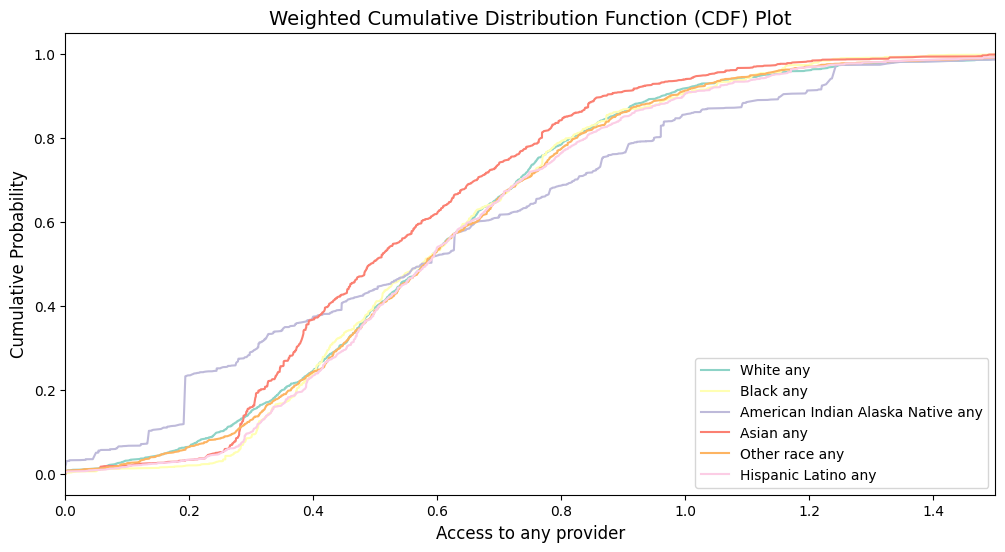

In [12]:
# CDF plot
race_variables1 = [
    "White any",
    "Black any",
    "American Indian Alaska Native any",
    "Asian any",
    "Other race any",
    "Hispanic Latino any",
]

colors = ["#8dd3c7", "#ffffb3", "#bebada", "#fb8072", "#fdb462", "#fccde5"]

weight_map1 = {
    "White any": "white",
    "Black any": "black",
    "American Indian Alaska Native any": "am_indian_alaska_native",
    "Asian any": "asian",
    "Other race any": "other_race",
    "Hispanic Latino any": "hispanic_latino",
}

fig, ax = plt.subplots(figsize=(12, 6))  # Increased the width of the figure

for var, color in zip(race_variables1, colors):
    # Get the weights for this variable
    weights = data[weight_map1[var]]

    # Sort the values and weights by the values
    values, weights = zip(*sorted(zip(data[var], weights)))

    # Calculate the cumulative sum of the weights
    cumulative = np.cumsum(weights)

    # Normalize the cumulative sum to create a CDF
    cumulative = cumulative / cumulative[-1]

    ax.plot(values, cumulative, label=var, color=color)

title_fontsize = 14
label_fontsize = 12
label_fontcolor = 'black'  # Setting a darker color for axis titles

ax.set_title("Weighted Cumulative Distribution Function (CDF) Plot", fontsize=title_fontsize)
ax.set_xlabel("Access to any provider", fontsize=label_fontsize, color=label_fontcolor)
ax.set_ylabel("Cumulative Probability", fontsize=label_fontsize, color=label_fontcolor)
ax.legend(loc="lower right")  # Changed the location of the legend to the southeast corner

# Set x-axis limit
ax.set_xlim(0, 1.5)

plt.show()

/tmp/ipykernel_1297/2716882622.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


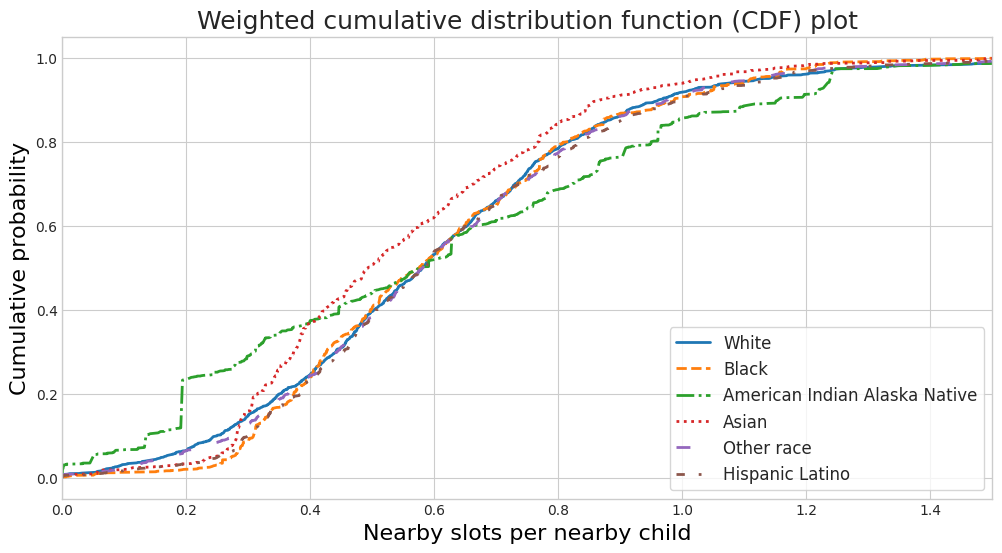

In [13]:
plt.style.use('seaborn-whitegrid')
colors = plt.cm.tab10.colors  # Using the 'tab10' colormap

fig, ax = plt.subplots(figsize=(12, 6))  # You can further adjust the width if needed

# Define line styles for better distinction
line_styles = ['-', '--', '-.', ':', (0, (5, 10)), (0, (3, 5, 1, 5))]  # Last two are custom linestyles

for i, var in enumerate(race_variables1):
    weights = data[weight_map1[var]]
    values, weights = zip(*sorted(zip(data[var], weights)))
    cumulative = np.cumsum(weights)
    cumulative = cumulative / cumulative[-1]
    label_without_any = var.replace(" any", "")
    color = colors[i % len(colors)] # Cycle through the colors
    style = line_styles[i % len(line_styles)] # Cycle through the line styles
    ax.plot(values, cumulative, label=label_without_any, color=color, linewidth=2, linestyle=style)

title_fontsize = 18
label_fontsize = 16  # Increased the font size for the axis titles
label_fontcolor = 'black'  # Setting a darker color for axis titles

ax.set_title("Weighted cumulative distribution function (CDF) plot", fontsize=title_fontsize)
ax.set_xlabel("Nearby slots per nearby child", fontsize=label_fontsize, color=label_fontcolor)
ax.set_ylabel("Cumulative probability", fontsize=label_fontsize, color=label_fontcolor)

# Moved legend to the southeast corner
ax.legend(loc="lower right", frameon=True, fontsize=12)

ax.set_xlim(0, 1.5)

plt.show()

In [14]:
percentiles1 = calculate_percentiles(data, race_variables1, weight_map1)
print(percentiles1)

                                   5th Percentile  10th Percentile  \
Race                                                                 
White any                                0.164371         0.249317   
Black any                                0.273894         0.308285   
American Indian Alaska Native any        0.051914         0.134712   
Asian any                                0.246184         0.280639   
Other race any                           0.170965         0.275060   
Hispanic Latino any                      0.251636         0.300442   

                                   15th Percentile  20th Percentile  \
Race                                                                  
White any                                 0.300371         0.351727   
Black any                                 0.332319         0.373387   
American Indian Alaska Native any         0.191642         0.192819   
Asian any                                 0.293629         0.315181   
Other race an

In [15]:
percentiles1_transposed = percentiles1.T
percentiles1_transposed.columns = [col.replace(" any", "") for col in percentiles1_transposed.columns]
percentiles1_transposed.head()

,White,Black,American Indian Alaska Native,Asian,Other race,Hispanic Latino
5th Percentile,0.164371,0.273894,0.051914,0.246184,0.170965,0.251636
10th Percentile,0.249317,0.308285,0.134712,0.280639,0.275060,0.300442
15th Percentile,0.300371,0.332319,0.191642,0.293629,0.318412,0.333442
20th Percentile,0.351727,0.373387,0.192819,0.315181,0.363949,0.384460
25th Percentile,0.403932,0.404378,0.244214,0.346209,0.412622,0.413841


In [16]:
percentiles1_transposed.to_csv('../data/percentiles1_2022.csv')

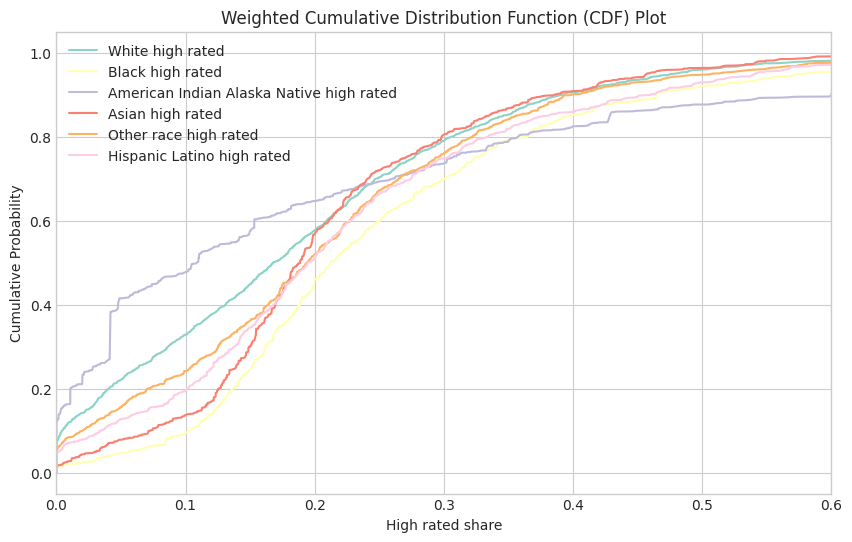

In [17]:
# CDF plot
race_variables2 = [
    "White high rated",
    "Black high rated",
    "American Indian Alaska Native high rated",
    "Asian high rated",
    "Other race high rated",
    "Hispanic Latino high rated",
]

colors = ["#8dd3c7", "#ffffb3", "#bebada", "#fb8072", "#fdb462", "#fccde5"]

weight_map2 = {
    "White high rated": "white",
    "Black high rated": "black",
    "American Indian Alaska Native high rated": "am_indian_alaska_native",
    "Asian high rated": "asian",
    "Other race high rated": "other_race",
    "Hispanic Latino high rated": "hispanic_latino",
}


fig, ax = plt.subplots(figsize=(10, 6))

for var, color in zip(race_variables2, colors):
    # Get the weights for this variable
    weights = data[weight_map2[var]]

    # Sort the values and weights by the values
    values, weights = zip(*sorted(zip(data[var], weights)))

    # Calculate the cumulative sum of the weights
    cumulative = np.cumsum(weights)

    # Normalize the cumulative sum to create a CDF
    cumulative = cumulative / cumulative[-1]

    ax.plot(values, cumulative, label=var, color=color)

ax.set_title("Weighted Cumulative Distribution Function (CDF) Plot")
ax.set_xlabel("High rated share")
ax.set_ylabel("Cumulative Probability")
ax.legend(loc="upper left")

# Set x-axis limit
ax.set_xlim(0, 0.6)

plt.show()

/tmp/ipykernel_1297/1758454039.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


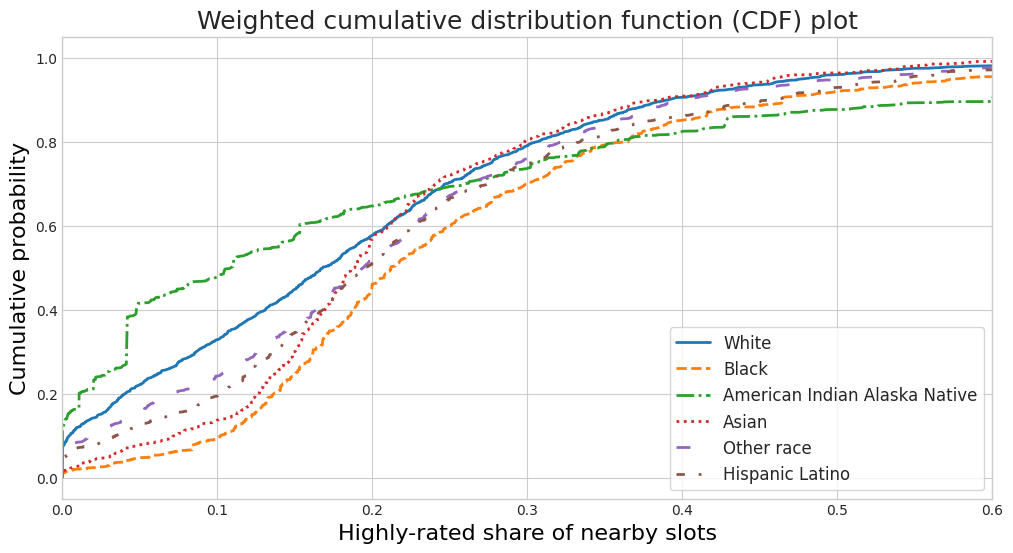

In [18]:
plt.style.use('seaborn-whitegrid')
colors = plt.cm.tab10.colors  # Using the 'tab10' colormap

fig, ax = plt.subplots(figsize=(12, 6))  # Increased the width of the figure

# Define line styles for better distinction
line_styles = ['-', '--', '-.', ':', (0, (5, 10)), (0, (3, 5, 1, 5))]  # Last two are custom linestyles

for i, var in enumerate(race_variables2):
    weights = data[weight_map2[var]]
    values, weights = zip(*sorted(zip(data[var], weights)))
    cumulative = np.cumsum(weights)
    cumulative = cumulative / cumulative[-1]
    label_without_high_rated = var.replace(" high rated", "")
    color = colors[i % len(colors)] # Cycle through the colors
    style = line_styles[i % len(line_styles)] # Cycle through the line styles
    ax.plot(values, cumulative, label=label_without_high_rated, color=color, linewidth=2, linestyle=style)

title_fontsize = 18
label_fontsize = 16  # Increased the font size for the axis titles
label_fontcolor = 'black'  # Setting a darker color for axis titles

ax.set_title("Weighted cumulative distribution function (CDF) plot", fontsize=title_fontsize)
ax.set_xlabel("Highly-rated share of nearby slots", fontsize=label_fontsize, color=label_fontcolor)
ax.set_ylabel("Cumulative probability", fontsize=label_fontsize, color=label_fontcolor)

# Moved legend to the southeast corner
ax.legend(loc="lower right", frameon=True, fontsize=12)

ax.set_xlim(0, 0.6)

plt.show()

In [19]:
percentiles2 = calculate_percentiles(data, race_variables2, weight_map2)
print(percentiles2)

                                          5th Percentile  10th Percentile  \
Race                                                                        
White high rated                                0.000002     4.439317e-03   
Black high rated                                0.056175     1.021368e-01   
American Indian Alaska Native high rated        0.000000     9.337272e-08   
Asian high rated                                0.030690     7.241049e-02   
Other race high rated                           0.000109     2.000089e-02   
Hispanic Latino high rated                      0.001734     3.408112e-02   

                                          15th Percentile  20th Percentile  \
Race                                                                         
White high rated                                 0.023714         0.040638   
Black high rated                                 0.122278         0.136625   
American Indian Alaska Native high rated         0.003473         0.010

In [20]:
percentiles2_transposed = percentiles2.T
percentiles2_transposed.columns = [col.replace(" high rated", "") for col in percentiles2_transposed.columns]
percentiles2_transposed.head()

,White,Black,American Indian Alaska Native,Asian,Other race,Hispanic Latino
5th Percentile,0.000002,0.056175,0.000000e+00,0.030690,0.000109,0.001734
10th Percentile,0.004439,0.102137,9.337272e-08,0.072410,0.020001,0.034081
15th Percentile,0.023714,0.122278,3.472796e-03,0.112540,0.047369,0.071069
20th Percentile,0.040638,0.136625,1.076237e-02,0.125648,0.070749,0.101137
25th Percentile,0.063470,0.151115,2.818063e-02,0.138818,0.103751,0.120647


In [21]:
percentiles2_transposed.to_csv('../data/percentiles2_2022.csv')

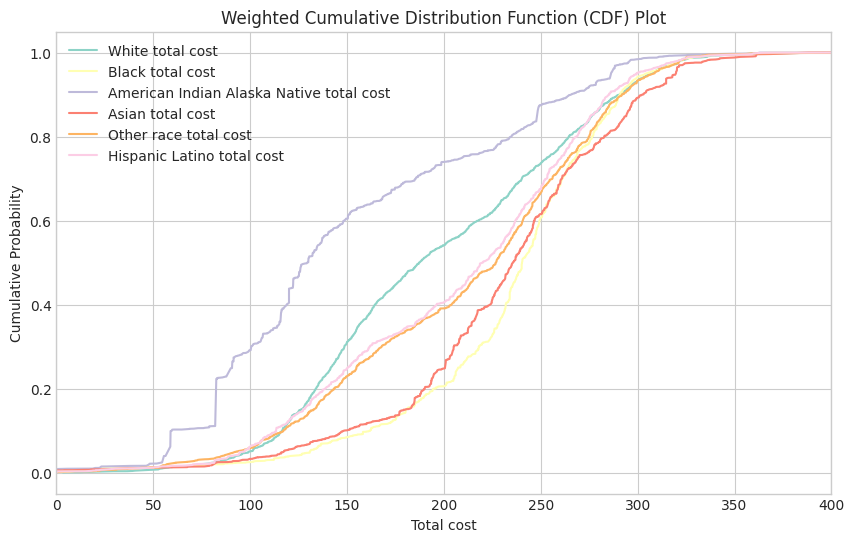

In [22]:
# CDF plot
race_variables3 = [
    "White total cost",
    "Black total cost",
    "American Indian Alaska Native total cost",
    "Asian total cost",
    "Other race total cost",
    "Hispanic Latino total cost",
]

colors = ["#8dd3c7", "#ffffb3", "#bebada", "#fb8072", "#fdb462", "#fccde5"]

weight_map3 = {
    "White total cost": "white",
    "Black total cost": "black",
    "American Indian Alaska Native total cost": "am_indian_alaska_native",
    "Asian total cost": "asian",
    "Other race total cost": "other_race",
    "Hispanic Latino total cost": "hispanic_latino",
}


fig, ax = plt.subplots(figsize=(10, 6))

for var, color in zip(race_variables3, colors):
    # Get the weights for this variable
    weights = data[weight_map3[var]]

    # Sort the values and weights by the values
    values, weights = zip(*sorted(zip(data[var], weights)))

    # Calculate the cumulative sum of the weights
    cumulative = np.cumsum(weights)

    # Normalize the cumulative sum to create a CDF
    cumulative = cumulative / cumulative[-1]

    ax.plot(values, cumulative, label=var, color=color)

ax.set_title("Weighted Cumulative Distribution Function (CDF) Plot")
ax.set_xlabel("Total cost")
ax.set_ylabel("Cumulative Probability")
ax.legend(loc="upper left")

# Set x-axis limit
ax.set_xlim(0, 400)

plt.show()

/tmp/ipykernel_1297/487092500.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


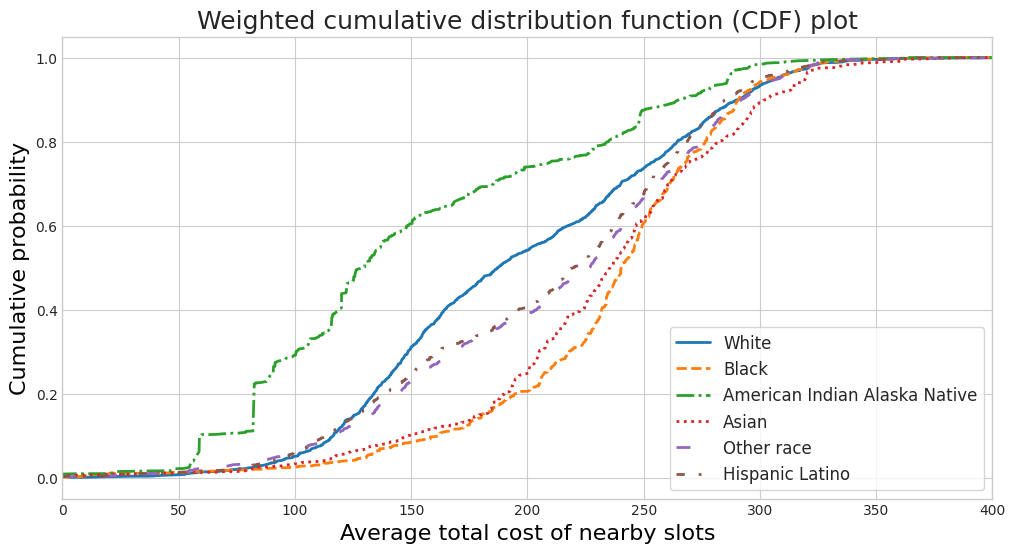

In [23]:
plt.style.use('seaborn-whitegrid')
colors = plt.cm.tab10.colors  # Using the 'tab10' colormap

fig, ax = plt.subplots(figsize=(12, 6))  # Increased the width of the figure

# Define line styles for better distinction
line_styles = ['-', '--', '-.', ':', (0, (5, 10)), (0, (3, 5, 1, 5))]  # Last two are custom linestyles

for i, var in enumerate(race_variables3):
    weights = data[weight_map3[var]]
    values, weights = zip(*sorted(zip(data[var], weights)))
    cumulative = np.cumsum(weights)
    cumulative = cumulative / cumulative[-1]
    label_without_suffix = var.replace(" total cost", "")  # Assuming "total cost" is the suffix you want to remove
    color = colors[i % len(colors)] # Cycle through the colors
    style = line_styles[i % len(line_styles)] # Cycle through the line styles
    ax.plot(values, cumulative, label=label_without_suffix, color=color, linewidth=2, linestyle=style)

title_fontsize = 18
label_fontsize = 16  # Increased the font size for the axis titles
label_fontcolor = 'black'  # Setting a darker color for axis titles

ax.set_title("Weighted cumulative distribution function (CDF) plot", fontsize=title_fontsize)
ax.set_xlabel("Average total cost of nearby slots", fontsize=label_fontsize, color=label_fontcolor)
ax.set_ylabel("Cumulative probability", fontsize=label_fontsize, color=label_fontcolor)

# Moved legend to the southeast corner
ax.legend(loc="lower right", frameon=True, fontsize=12)

ax.set_xlim(0, 400)

plt.show()

In [24]:
percentiles3 = calculate_percentiles(data, race_variables3, weight_map3)
print(percentiles3)

                                          5th Percentile  10th Percentile  \
Race                                                                        
White total cost                               99.402040       116.509400   
Black total cost                              130.802575       161.942819   
American Indian Alaska Native total cost       57.473087        59.541074   
Asian total cost                              117.335137       148.634821   
Other race total cost                          93.058784       117.290684   
Hispanic Latino total cost                     96.363380       113.347703   

                                          15th Percentile  20th Percentile  \
Race                                                                         
White total cost                               126.144866       133.948620   
Black total cost                               180.385072       195.451253   
American Indian Alaska Native total cost        82.141682        82.397

In [25]:
percentiles3_transposed = percentiles3.T
percentiles3_transposed.columns = [col.replace(" high rated", "") for col in percentiles3_transposed.columns]
percentiles3_transposed.head()

,White total cost,Black total cost,American Indian Alaska Native total cost,Asian total cost,Other race total cost,Hispanic Latino total cost
5th Percentile,99.402040,130.802575,57.473087,117.335137,93.058784,96.363380
10th Percentile,116.509400,161.942819,59.541074,148.634821,117.290684,113.347703
15th Percentile,126.144866,180.385072,82.141682,180.129778,132.657732,127.335555
20th Percentile,133.948620,195.451253,82.397667,190.081264,143.357738,138.904633
25th Percentile,141.683781,207.343354,90.630070,200.562784,154.819391,150.328948


In [26]:
percentiles3_transposed.to_csv('../data/percentiles3_2022.csv')

## Matrix of Differences

In [27]:
# Read the CSV file into a DataFrame
# matrix_data = pd.read_csv("../data/matrix_of_differences.csv", index_col=0)

# # Convert 'state', 'county', and 'tract' to strings
# matrix_data["state"] = matrix_data["state"].astype(str)
# matrix_data["county"] = matrix_data["county"].astype(str)
# matrix_data["tract"] = matrix_data["tract"].astype(str)

# # Convert all other columns to numeric
# for column in matrix_data.columns:
#     if column not in ["state", "county", "tract"]:
#         matrix_data[column] = pd.to_numeric(matrix_data[column], errors="coerce")

# # Display the first few rows to check the result
# matrix_data.head()

In [28]:
list_of_weights = list(set(racial_weights)) + ["state", "county", "tract"]
print(list_of_weights)

['white', 'hispanic_latino', 'asian', 'other_race', 'am_indian_alaska_native', 'black', 'state', 'county', 'tract']


In [29]:
# matrix_data = data[list_of_weights]
# matrix_data.columns

In [30]:
# CDF plot
race_variables1 = [
    "White any",
    "Black any",
    "American Indian Alaska Native any",
    "Asian any",
    "Other race any",
    "Hispanic Latino any",
]

weight_map1 = {
    "White any": "white",
    "Black any": "black",
    "American Indian Alaska Native any": "am_indian_alaska_native",
    "Asian any": "asian",
    "Other race any": "other_race",
    "Hispanic Latino any": "hispanic_latino",
}

# weight_map1 = {
#     "White any": "Share of White Population",
#     "Black any": "Share of Black Population",
#     "American Indian Alaska Native any": "Share of American Indian and Alaska Native Population",
#     "Asian any": "Share of Asian Population",
#     "Other race any": "Share of Other Race Population",
#     "Hispanic Latino any": "Share of Hispanic or Latino Population",
# }

In [31]:
# List of columns to drop
# columns_to_drop = [
#     "Share of White Population",
#     "Share of Black Population",
#     "Share of American Indian and Alaska Native Population",
#     "Share of Asian Population",
#     "Share of Other Race Population",
#     "Share of Hispanic or Latino Population",
# ]

# # Drop only the columns that exist in the data
# columns_to_drop_exist = [col for col in columns_to_drop if col in data.columns]
# data_dropped_columns = data.drop(columns=columns_to_drop_exist)

# # Perform a left merge with matrix_data on the key variables
# merged_data = pd.merge(
#     data_dropped_columns, matrix_data, how="left", on=["state", "county", "tract"]
# )

merged_data = data.copy()

In [32]:
# Create an empty dataframe for the significance
significance_matrix1 = pd.DataFrame(index=race_variables1, columns=race_variables1)
# Create an empty dataframe for the matrix of mean differences
matrix1 = pd.DataFrame(index=race_variables1, columns=race_variables1)
# Create an empty dataframe for the matrix of p-values
pvalue_matrix1 = pd.DataFrame(index=race_variables1, columns=race_variables1)

for row_var in race_variables1:
    for col_var in race_variables1:
        if row_var != col_var:
            row_sample = merged_data[row_var]
            col_sample = merged_data[col_var]
            row_weights = merged_data[weight_map1[row_var]]
            col_weights = merged_data[weight_map1[col_var]]

            # Fix the weights
            row_weights_fixed = row_weights + 0.000005
            col_weights_fixed = col_weights + 0.000005
            
            t_stat, p_value, _ = ttest_ind(row_sample, col_sample, 
                                           weights=(row_weights_fixed, col_weights_fixed), 
                                           usevar='unequal') # You can also use 'pooled'

            row_weighted_mean = (row_sample * row_weights).sum() 
            col_weighted_mean = (col_sample * col_weights).sum() 

            print("T-statistic:", t_stat)
            print("P-value:", p_value)

            matrix1.loc[row_var, col_var] = row_weighted_mean - col_weighted_mean
            significance_matrix1.loc[row_var, col_var] = "**" if p_value < 0.05 else "NS"
            pvalue_matrix1.loc[row_var, col_var] = p_value

T-statistic: -0.0005154190426784265
P-value: 0.9999608762661597
T-statistic: -0.00021716052820873274
P-value: 0.9999958388234534
T-statistic: 0.004017498736555208
P-value: 0.9999117573955041
T-statistic: -0.0007028606063950795
P-value: 0.9999525019223823
T-statistic: -0.002725345107099994
P-value: 0.9997431583269928
T-statistic: 0.0005154190426784265
P-value: 0.9999608762661597
T-statistic: -7.346858101919856e-05
P-value: 0.9999985767439895
T-statistic: 0.00420001810213347
P-value: 0.9999046220361423
T-statistic: -0.00022899833294625602
P-value: 0.9999846562212162
T-statistic: -0.0019908220792541676
P-value: 0.9998508477126411
T-statistic: 0.00021716052820873274
P-value: 0.9999958388234534
T-statistic: 7.346858101919856e-05
P-value: 0.9999985767439895
T-statistic: 0.002206624421999474
P-value: 0.9999492126853612
T-statistic: -1.2394486483072862e-06
P-value: 0.9999999755356951
T-statistic: -0.0004707721635832354
P-value: 0.9999910033327404
T-statistic: -0.004017498736555208
P-value: 0.9

In [33]:
matrix1

,White any,Black any,American Indian Alaska Native any,Asian any,Other race any,Hispanic Latino any
White any,NaN,-0.002906,-0.004902,0.059692,-0.004302,-0.017848
Black any,0.002906,NaN,-0.001996,0.062597,-0.001397,-0.014942
American Indian Alaska Native any,0.004902,0.001996,NaN,0.064593,0.000599,-0.012946
Asian any,-0.059692,-0.062597,-0.064593,NaN,-0.063994,-0.077539
Other race any,0.004302,0.001397,-0.000599,0.063994,NaN,-0.013545
Hispanic Latino any,0.017848,0.014942,0.012946,0.077539,0.013545,NaN


In [34]:
matrix1.to_csv('../data/matrix1_2022.csv')

In [35]:
significance_matrix1

,White any,Black any,American Indian Alaska Native any,Asian any,Other race any,Hispanic Latino any
White any,NaN,NS,NS,NS,NS,NS
Black any,NS,NaN,NS,NS,NS,NS
American Indian Alaska Native any,NS,NS,NaN,NS,NS,NS
Asian any,NS,NS,NS,NaN,NS,NS
Other race any,NS,NS,NS,NS,NaN,NS
Hispanic Latino any,NS,NS,NS,NS,NS,NaN


In [36]:
significance_matrix1.to_csv('../data/significance_matrix1_2022.csv')

In [37]:
pvalue_matrix1

,White any,Black any,American Indian Alaska Native any,Asian any,Other race any,Hispanic Latino any
White any,NaN,0.999961,0.999996,0.999912,0.999953,0.999743
Black any,0.999961,NaN,0.999999,0.999905,0.999985,0.999851
American Indian Alaska Native any,0.999996,0.999999,NaN,0.999949,1.0,0.999991
Asian any,0.999912,0.999905,0.999949,NaN,0.999899,0.999886
Other race any,0.999953,0.999985,1.0,0.999899,NaN,0.999898
Hispanic Latino any,0.999743,0.999851,0.999991,0.999886,0.999898,NaN


In [38]:
pvalue_matrix1.to_csv('../data/pvalue_matrix1_2022.csv')

In [39]:
# CDF plot
race_variables2 = [
    "White high rated",
    "Black high rated",
    "American Indian Alaska Native high rated",
    "Asian high rated",
    "Other race high rated",
    "Hispanic Latino high rated",
]

# weight_map2 = {
#     "White high rated": "Share of White Population",
#     "Black high rated": "Share of Black Population",
#     "American Indian Alaska Native high rated": "Share of American Indian and Alaska Native Population",
#     "Asian high rated": "Share of Asian Population",
#     "Other race high rated": "Share of Other Race Population",
#     "Hispanic Latino high rated": "Share of Hispanic or Latino Population",
# }

weight_map2 = {
    "White high rated": "white",
    "Black high rated": "black",
    "American Indian Alaska Native high rated": "am_indian_alaska_native",
    "Asian high rated": "asian",
    "Other race high rated": "other_race",
    "Hispanic Latino high rated": "hispanic_latino",
}

In [40]:
# Create an empty dataframe for the significance
significance_matrix2 = pd.DataFrame(index=race_variables2, columns=race_variables2)
# Create an empty dataframe for the matrix of mean differences
matrix2 = pd.DataFrame(index=race_variables2, columns=race_variables2)
# Create an empty dataframe for the matrix of p-values
pvalue_matrix2 = pd.DataFrame(index=race_variables2, columns=race_variables2)

for row_var in race_variables2:
    for col_var in race_variables2:
        if row_var != col_var:
            row_sample = merged_data[row_var]
            col_sample = merged_data[col_var]
            row_weights = merged_data[weight_map2[row_var]]
            col_weights = merged_data[weight_map2[col_var]]

            # Fix the weights
            row_weights_fixed = row_weights + 0.000005
            col_weights_fixed = col_weights + 0.000005
            
            t_stat, p_value, _ = ttest_ind(row_sample, col_sample, 
                                           weights=(row_weights_fixed, col_weights_fixed), 
                                           usevar='unequal') # You can also use 'pooled'

            row_weighted_mean = (row_sample * row_weights).sum() 
            col_weighted_mean = (col_sample * col_weights).sum() 

            matrix2.loc[row_var, col_var] = row_weighted_mean - col_weighted_mean
            significance_matrix2.loc[row_var, col_var] = "**" if p_value < 0.05 else "NS"
            pvalue_matrix2.loc[row_var, col_var] = p_value

In [41]:
matrix2

,White high rated,Black high rated,American Indian Alaska Native high rated,Asian high rated,Other race high rated,Hispanic Latino high rated
White high rated,NaN,-0.059815,-0.01904,-0.020456,-0.02227,-0.033444
Black high rated,0.059815,NaN,0.040775,0.039359,0.037545,0.026371
American Indian Alaska Native high rated,0.01904,-0.040775,NaN,-0.001416,-0.00323,-0.014404
Asian high rated,0.020456,-0.039359,0.001416,NaN,-0.001814,-0.012988
Other race high rated,0.02227,-0.037545,0.00323,0.001814,NaN,-0.011174
Hispanic Latino high rated,0.033444,-0.026371,0.014404,0.012988,0.011174,NaN


In [42]:
matrix2.to_csv('../data/matrix2_2022.csv')

In [43]:
significance_matrix2

,White high rated,Black high rated,American Indian Alaska Native high rated,Asian high rated,Other race high rated,Hispanic Latino high rated
White high rated,NaN,NS,NS,NS,NS,NS
Black high rated,NS,NaN,NS,NS,NS,NS
American Indian Alaska Native high rated,NS,NS,NaN,NS,NS,NS
Asian high rated,NS,NS,NS,NaN,NS,NS
Other race high rated,NS,NS,NS,NS,NaN,NS
Hispanic Latino high rated,NS,NS,NS,NS,NS,NaN


In [44]:
significance_matrix2.to_csv('../data/significance_matrix2_2022.csv')

In [45]:
pvalue_matrix2

,White high rated,Black high rated,American Indian Alaska Native high rated,Asian high rated,Other race high rated,Hispanic Latino high rated
White high rated,NaN,0.998871,0.99998,0.999932,0.999672,0.999106
Black high rated,0.998871,NaN,0.999957,0.999872,0.999486,0.999494
American Indian Alaska Native high rated,0.99998,0.999957,NaN,0.999998,0.999996,0.999985
Asian high rated,0.999932,0.999872,0.999998,NaN,0.999995,0.999961
Other race high rated,0.999672,0.999486,0.999996,0.999995,NaN,0.999846
Hispanic Latino high rated,0.999106,0.999494,0.999985,0.999961,0.999846,NaN


In [46]:
pvalue_matrix2.to_csv('../data/pvalue_matrix2_2022.csv')

In [47]:
# CDF plot
race_variables3 = [
    "White total cost",
    "Black total cost",
    "American Indian Alaska Native total cost",
    "Asian total cost",
    "Other race total cost",
    "Hispanic Latino total cost",
]

# weight_map3 = {
#     "White total cost": "Share of White Population",
#     "Black total cost": "Share of Black Population",
#     "American Indian Alaska Native total cost": "Share of American Indian and Alaska Native Population",
#     "Asian total cost": "Share of Asian Population",
#     "Other race total cost": "Share of Other Race Population",
#     "Hispanic Latino total cost": "Share of Hispanic or Latino Population",
# }

weight_map3 = {
    "White total cost": "white",
    "Black total cost": "black",
    "American Indian Alaska Native total cost": "am_indian_alaska_native",
    "Asian total cost": "asian",
    "Other race total cost": "other_race",
    "Hispanic Latino total cost": "hispanic_latino",
}

In [48]:
# Create an empty dataframe for the significance
significance_matrix3 = pd.DataFrame(index=race_variables3, columns=race_variables3)
# Create an empty dataframe for the matrix of mean differences
matrix3 = pd.DataFrame(index=race_variables3, columns=race_variables3)
# Create an empty dataframe for the matrix of p-values
pvalue_matrix3 = pd.DataFrame(index=race_variables3, columns=race_variables3)

for row_var in race_variables3:
    for col_var in race_variables3:
        if row_var != col_var:
            row_sample = merged_data[row_var]
            col_sample = merged_data[col_var]
            row_weights = merged_data[weight_map3[row_var]]
            col_weights = merged_data[weight_map3[col_var]]

              # Fix the weights
            row_weights_fixed = row_weights + 0.000005
            col_weights_fixed = col_weights + 0.000005
            
            t_stat, p_value, _ = ttest_ind(row_sample, col_sample, 
                                           weights=(row_weights_fixed, col_weights_fixed), 
                                           usevar='unequal') # You can also use 'pooled'

            row_weighted_mean = (row_sample * row_weights).sum() 
            col_weighted_mean = (col_sample * col_weights).sum() 

            matrix3.loc[row_var, col_var] = row_weighted_mean - col_weighted_mean
            significance_matrix3.loc[row_var, col_var] = "**" if p_value < 0.05 else "NS"
            pvalue_matrix3.loc[row_var, col_var] = p_value

In [49]:
matrix3

,White total cost,Black total cost,American Indian Alaska Native total cost,Asian total cost,Other race total cost,Hispanic Latino total cost
White total cost,NaN,-35.641953,46.404221,-33.205261,-13.985992,-10.713745
Black total cost,35.641953,NaN,82.046173,2.436691,21.65596,24.928207
American Indian Alaska Native total cost,-46.404221,-82.046173,NaN,-79.609482,-60.390213,-57.117966
Asian total cost,33.205261,-2.436691,79.609482,NaN,19.219269,22.491516
Other race total cost,13.985992,-21.65596,60.390213,-19.219269,NaN,3.272247
Hispanic Latino total cost,10.713745,-24.928207,57.117966,-22.491516,-3.272247,NaN


In [50]:
matrix3.to_csv('../data/matrix3_2022.csv')

In [51]:
significance_matrix3

,White total cost,Black total cost,American Indian Alaska Native total cost,Asian total cost,Other race total cost,Hispanic Latino total cost
White total cost,NaN,NS,NS,NS,NS,NS
Black total cost,NS,NaN,NS,NS,NS,NS
American Indian Alaska Native total cost,NS,NS,NaN,NS,NS,NS
Asian total cost,NS,NS,NS,NaN,NS,NS
Other race total cost,NS,NS,NS,NS,NaN,NS
Hispanic Latino total cost,NS,NS,NS,NS,NS,NaN


In [52]:
significance_matrix3.to_csv('../data/significance_matrix3_2022.csv')

In [53]:
pvalue_matrix3

,White total cost,Black total cost,American Indian Alaska Native total cost,Asian total cost,Other race total cost,Hispanic Latino total cost
White total cost,NaN,0.998195,0.999791,0.999781,0.999462,0.999303
Black total cost,0.998195,NaN,0.999654,0.999987,0.999236,0.998713
American Indian Alaska Native total cost,0.999791,0.999654,NaN,0.999615,0.999723,0.999748
Asian total cost,0.999781,0.999987,0.999615,NaN,0.999865,0.999847
Other race total cost,0.999462,0.999236,0.999723,0.999865,NaN,0.999858
Hispanic Latino total cost,0.999303,0.998713,0.999748,0.999847,0.999858,NaN


In [54]:
pvalue_matrix3.to_csv('../data/pvalue_matrix3_2022.csv')

## Matrix of Differences with color

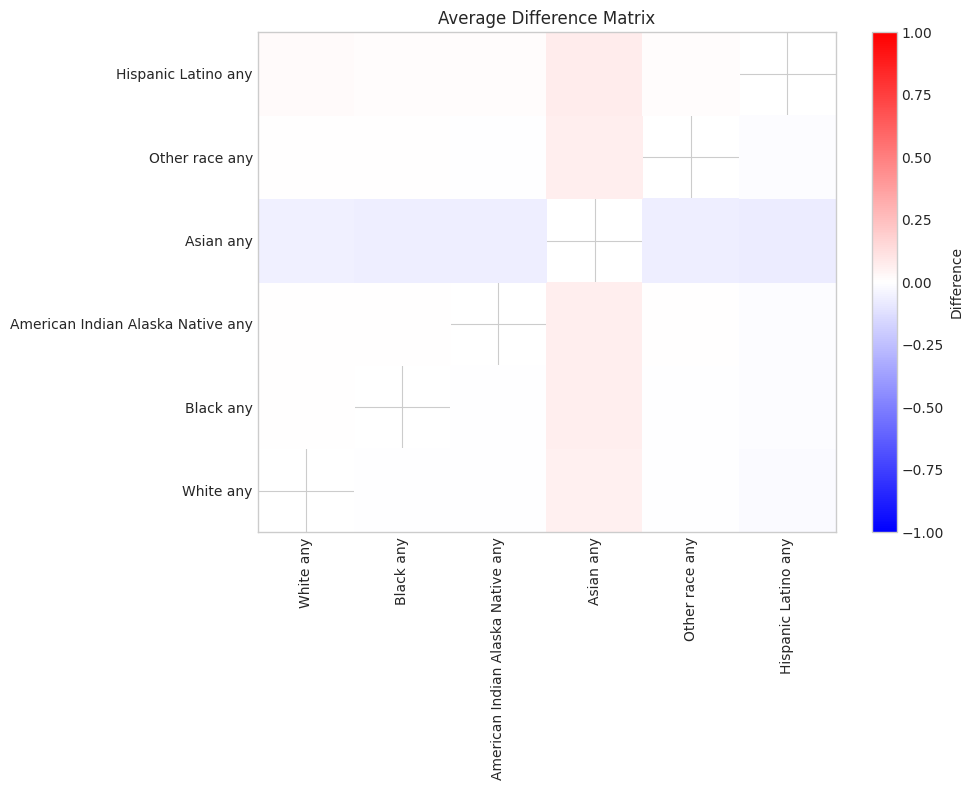

In [55]:
# Matrix of differences

# Color matrix
# Convert the matrix to numeric
matrix1 = matrix1.astype(float)
# Use a diverging colormap (blue for negative, white for zero, red for positive)
colormap = plt.get_cmap("bwr")

plt.figure(figsize=(10, 8))
plt.pcolor(matrix1, cmap=colormap, vmin=-1, vmax=1)
plt.colorbar(label="Difference")
plt.xticks(
    np.arange(0.5, len(matrix1.columns), 1),
    matrix1.columns,
    rotation="vertical",
    fontsize=10,
)
plt.yticks(np.arange(0.5, len(matrix1.index), 1), matrix1.index, fontsize=10)
plt.title("Average Difference Matrix")
plt.tight_layout()  # this helps to ensure that labels fit into the figure area
plt.show()

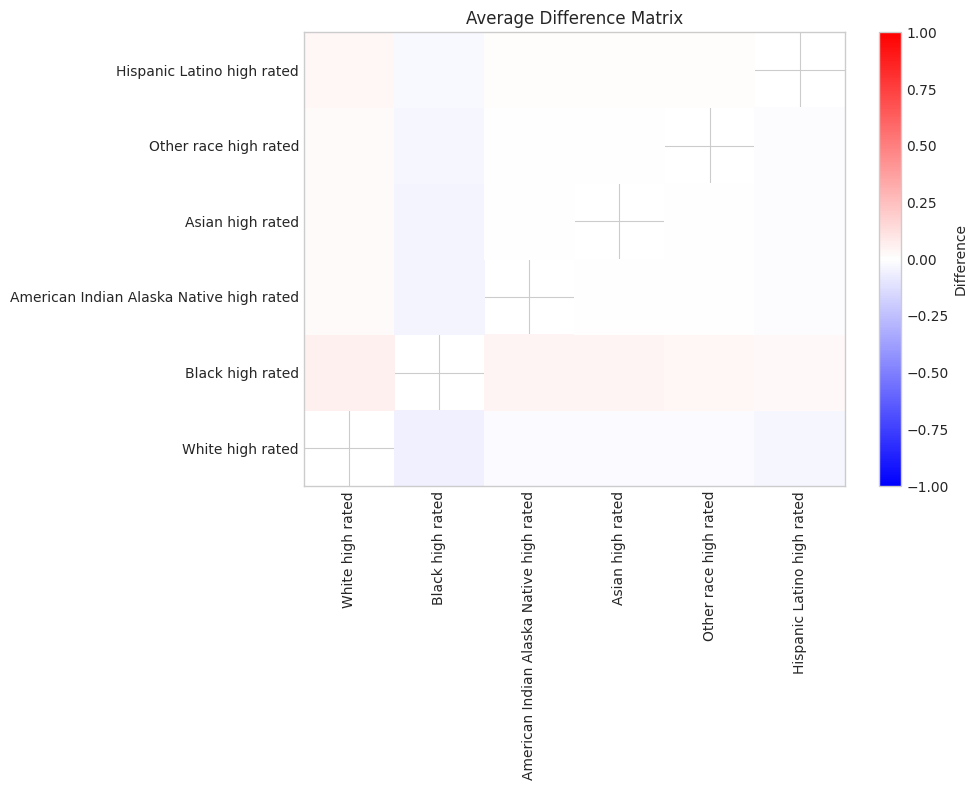

In [56]:
# Matrix of differences

# Color matrix
# Convert the matrix to numeric
matrix2 = matrix2.astype(float)
# Use a diverging colormap (blue for negative, white for zero, red for positive)
colormap = plt.get_cmap("bwr")

plt.figure(figsize=(10, 8))
plt.pcolor(matrix2, cmap=colormap, vmin=-1, vmax=1)
plt.colorbar(label="Difference")
plt.xticks(
    np.arange(0.5, len(matrix2.columns), 1),
    matrix2.columns,
    rotation="vertical",
    fontsize=10,
)
plt.yticks(np.arange(0.5, len(matrix2.index), 1), matrix2.index, fontsize=10)
plt.title("Average Difference Matrix")
plt.tight_layout()  # this helps to ensure that labels fit into the figure area
plt.show()

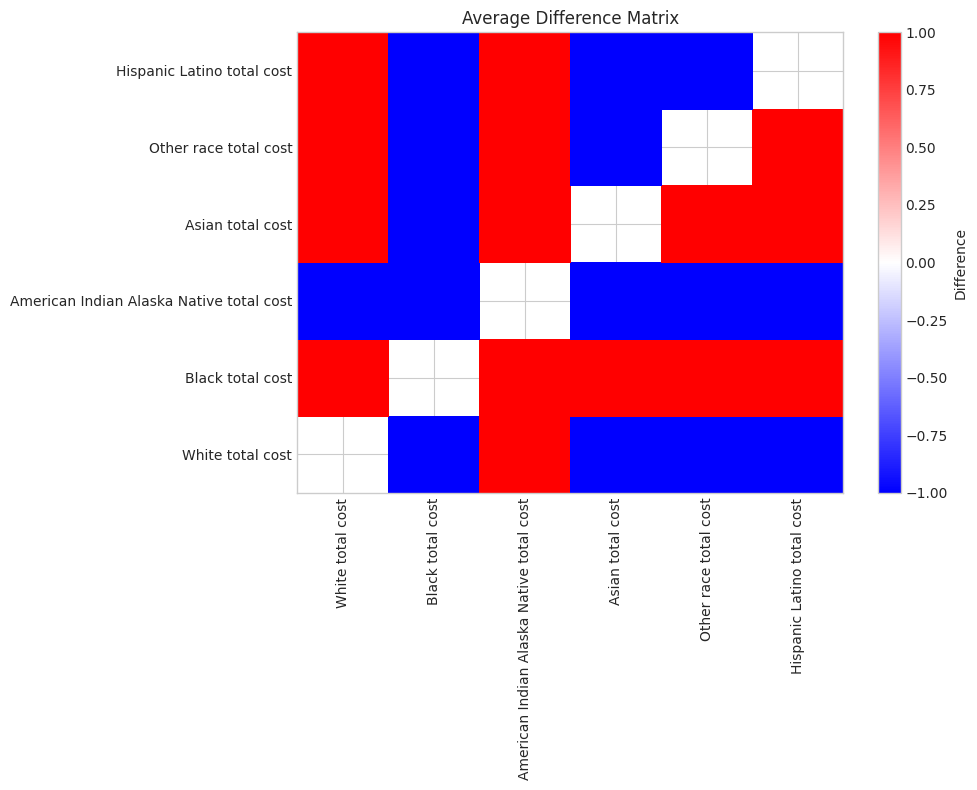

In [57]:
# Matrix of differences

# Color matrix
# Convert the matrix to numeric
matrix3 = matrix3.astype(float)
# Use a diverging colormap (blue for negative, white for zero, red for positive)
colormap = plt.get_cmap("bwr")

plt.figure(figsize=(10, 8))
plt.pcolor(matrix3, cmap=colormap, vmin=-1, vmax=1)
plt.colorbar(label="Difference")
plt.xticks(
    np.arange(0.5, len(matrix3.columns), 1),
    matrix3.columns,
    rotation="vertical",
    fontsize=10,
)
plt.yticks(np.arange(0.5, len(matrix3.index), 1), matrix3.index, fontsize=10)
plt.title("Average Difference Matrix")
plt.tight_layout()  # this helps to ensure that labels fit into the figure area
plt.show()

In [58]:
# Create a scatter plot using the summary_df dataframe
filtered_summary_statistics_df = summary_statistics_df[~summary_statistics_df.index.str.contains('any')]
filtered_summary_statistics_df = filtered_summary_statistics_df["Mean"]
# Reset the index to make it into a column
filtered_summary_statistics_df = filtered_summary_statistics_df.reset_index()

# Rename the columns
filtered_summary_statistics_df.columns = ['name', 'mean']

# Define a function to split the name into the race and type of measure
def split_name(name):
    if 'high rated' in name:
        race = name.replace(' high rated', '')
        measure = 'high rated'
    elif 'total cost' in name:
        race = name.replace(' total cost', '')
        measure = 'total cost'
    else:
        race = name
        measure = None

    return race, measure

# Apply the function to the 'name' column and create two new columns
filtered_summary_statistics_df[['race', 'type_of_measure']] = filtered_summary_statistics_df['name'].apply(lambda x: pd.Series(split_name(x)))

# Drop the original 'name' column
filtered_summary_statistics_df = filtered_summary_statistics_df.drop(columns=['name'])

filtered_summary_statistics_df = filtered_summary_statistics_df.dropna(subset=['type_of_measure'])


filtered_summary_statistics_df

,mean,race,type_of_measure
0,0.19,White,high rated
1,196.09,White,total cost
2,0.25,Black,high rated
3,231.73,Black,total cost
4,0.21,American Indian Alaska Native,high rated
5,149.69,American Indian Alaska Native,total cost
6,0.21,Asian,high rated
7,229.30,Asian,total cost
8,0.21,Other race,high rated
9,210.08,Other race,total cost


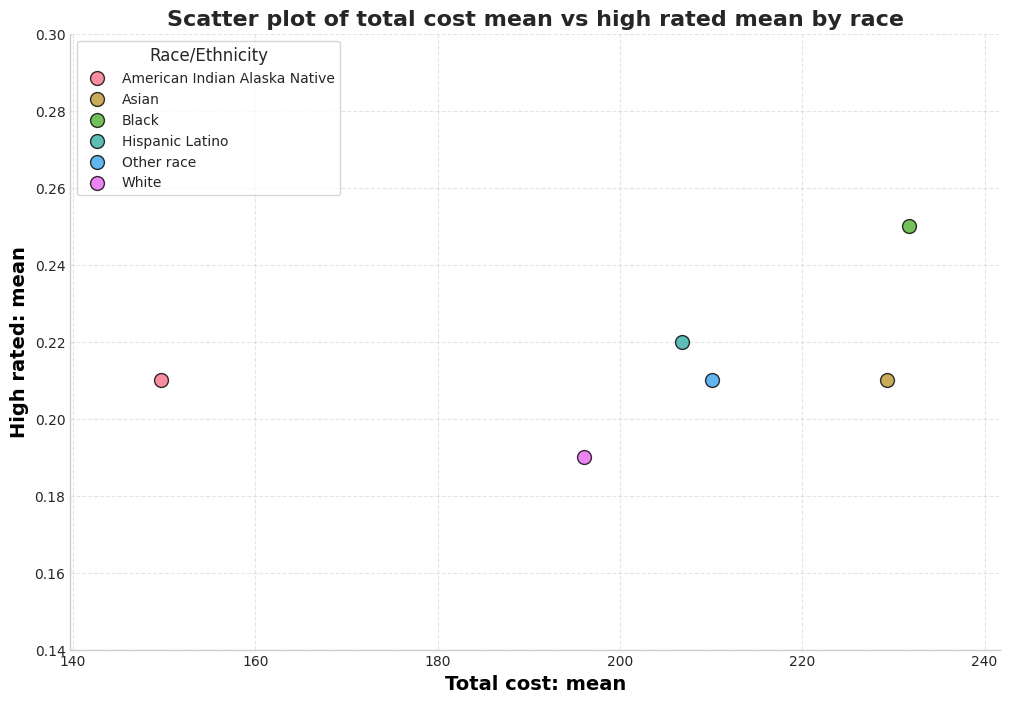

In [59]:
# Convert 'mean' to a numeric type, if it's not already
filtered_summary_statistics_df['mean'] = pd.to_numeric(filtered_summary_statistics_df['mean'], errors='coerce')

# Pivot the DataFrame to have 'type_of_measure' as columns and 'race' as index
pivot_df = filtered_summary_statistics_df.pivot(index='race', columns='type_of_measure', values='mean')

# Separate the means for 'total cost' and 'high rated'
x_values = pivot_df['total cost']
y_values = pivot_df['high rated']

# Get the unique races
races = pivot_df.index

# Define a color palette with Seaborn
colors = sns.color_palette("husl", n_colors=len(races))

# Create the plot figure
plt.figure(figsize=(12, 8))

# Plot the scatter plot for each race
for i, race in enumerate(races):
    plt.scatter(x_values[race], y_values[race], color=colors[i], s=100, edgecolor='black', linewidth=1, label=race, alpha=0.8)

# Format the x and y labels
plt.xlabel('Total cost: mean', fontsize=14, weight='bold', color='black')
plt.ylabel('High rated: mean', fontsize=14, weight='bold', color='black')

# Add a title
plt.title('Scatter plot of total cost mean vs high rated mean by race', fontsize=16, weight='bold')

# Add a legend
plt.legend(title='Race', fontsize=10, title_fontsize=12, frameon=True)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Use seaborn styling
sns.despine()

# Set axis limits (optional, can be adjusted)
plt.xlim(min(x_values) - 10, max(x_values) + 10)
plt.ylim(min(y_values) - 0.05, max(y_values) + 0.05)

# Add a legend in the upper left corner
plt.legend(title='Race/Ethnicity', fontsize=10, title_fontsize=12, frameon=True, loc='upper left')

# Show the plot
plt.show()

In [60]:
p_1 = percentiles3[~percentiles3.index.str.contains('any')]
p_2 = percentiles2[~percentiles2.index.str.contains('any')]
p_1 = p_1.reset_index()
p_2 = p_2.reset_index()
p_1 = p_1[["Race","50th Percentile"]]
p_2 = p_2[["Race","50th Percentile"]]
# append the two dataframes one on top of the other
p_df = pd.concat([p_1, p_2], axis=0)
# Rename the 50th Percentile column
p_df = p_df.rename(columns={"50th Percentile": "median"})
# Apply the function to the 'name' column and create two new columns
p_df[['race', 'type_of_measure']] = p_df['Race'].apply(lambda x: pd.Series(split_name(x)))

# Drop the original 'name' column
p_df = p_df.drop(columns=['Race'])

p_df

,median,race,type_of_measure
0,187.182584,White,total cost
1,240.300068,Black,total cost
2,129.416162,American Indian Alaska Native,total cost
3,235.615686,Asian,total cost
4,226.821407,Other race,total cost
5,220.092317,Hispanic Latino,total cost
0,0.167963,White,high rated
1,0.211907,Black,high rated
2,0.108707,American Indian Alaska Native,high rated
3,0.188685,Asian,high rated


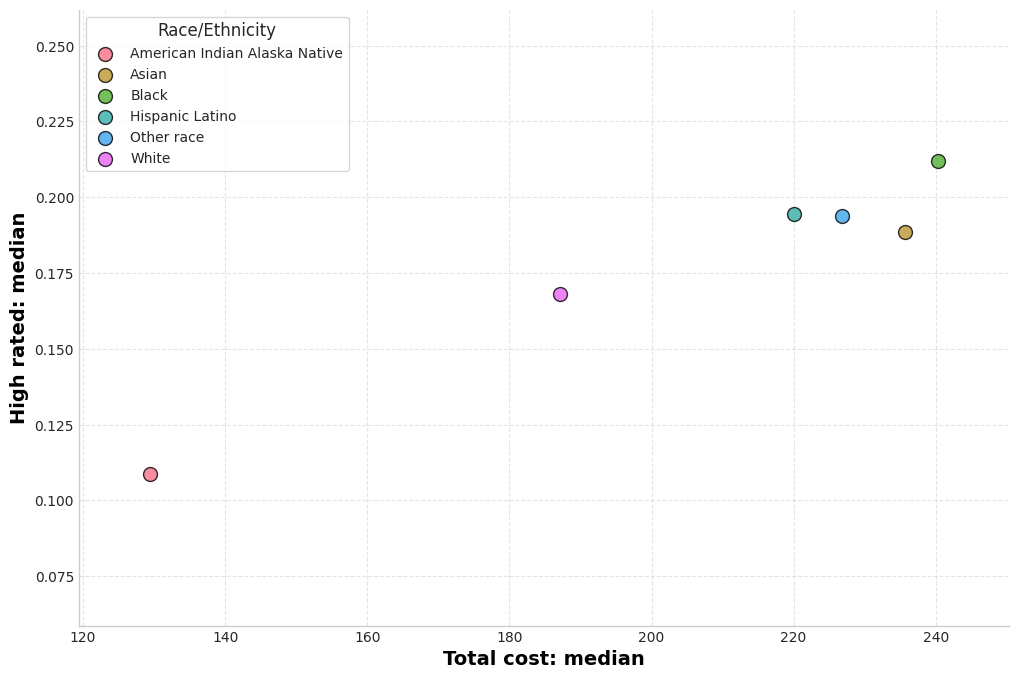

In [61]:
# Convert 'mean' to a numeric type, if it's not already
p_df['median'] = pd.to_numeric(p_df['median'], errors='coerce')

# Pivot the DataFrame to have 'type_of_measure' as columns and 'race' as index
pivot_df = p_df.pivot(index='race', columns='type_of_measure', values='median')

# Separate the means for 'total cost' and 'high rated'
x_values = pivot_df['total cost']
y_values = pivot_df['high rated']

# Get the unique races
races = pivot_df.index

# Define a color palette with Seaborn
colors = sns.color_palette("husl", n_colors=len(races))

# Create the plot figure
plt.figure(figsize=(12, 8))

# Plot the scatter plot for each race
for i, race in enumerate(races):
    plt.scatter(x_values[race], y_values[race], color=colors[i], s=100, edgecolor='black', linewidth=1, label=race, alpha=0.8)

# Format the x and y labels
plt.xlabel('Total cost: median', fontsize=14, weight='bold', color='black')
plt.ylabel('High rated: median', fontsize=14, weight='bold', color='black')

# Add a title
#plt.title('Scatter plot of total cost mean vs high rated mean by race', fontsize=16, weight='bold')

# Add a legend
plt.legend(title='Race', fontsize=10, title_fontsize=12, frameon=True)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Use seaborn styling
sns.despine()

# Set axis limits (optional, can be adjusted)
plt.xlim(min(x_values) - 10, max(x_values) + 10)
plt.ylim(min(y_values) - 0.05, max(y_values) + 0.05)

# Add a legend in the upper left corner
plt.legend(title='Race/Ethnicity', fontsize=10, title_fontsize=12, frameon=True, loc='upper left')

# Show the plot
plt.show()